In [3]:
# Uncomment to install `sklearn-pandas`
! pip install sklearn-pandas

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [56]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [60]:
df_train = pd.read_csv("processed_data.csv")
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,Volume,Mean,Std,Min,Max,Median,SurfaceArea,Elongation,Flatness,Roundness,Time to Event,Event
0,2719,-139.272894,194.164635,-812,154,-56.236328,826.137989,1.436361,1.446431,0.699813,3078,0
1,2150,-105.572558,173.439744,-829,144,-36.021484,1037.374063,1.367921,1.112439,0.781205,70,0
3,1547,-74.679379,254.147443,-1024,366,21.595703,912.514223,1.593605,1.631120,0.639694,1172,0
5,7050,-173.679007,202.738563,-844,88,-103.359375,1982.069341,1.242244,1.341162,0.635347,2297,0
7,7257,-452.782279,257.238450,-970,385,-515.501953,2147.002738,1.054686,1.549855,0.753874,2298,0


In [61]:
cols_standardize = []
cols_leave = ['Volume', 'Mean', 'Std', 'Min', 'Max', 'Median', 'SurfaceArea', 'Elongation', 'Flatness', 'Roundness']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [62]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [63]:
get_target = lambda df: (df['Time to Event'].values, df['Event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [64]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [65]:
model = CoxPH(net, tt.optim.Adam)

c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwarg

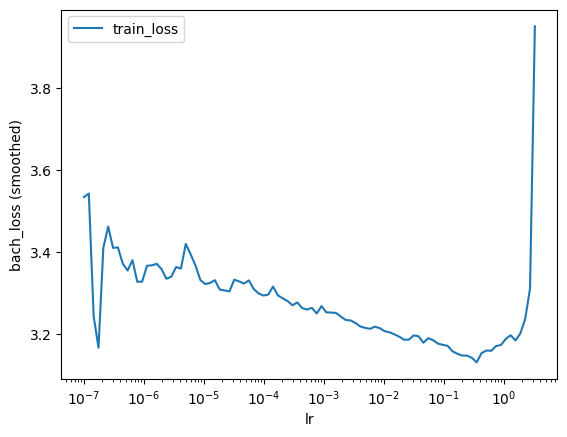

In [66]:
batch_size = 32
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [67]:
lrfinder.get_best_lr()

0.035111917342151515

In [68]:
model.optimizer.set_lr(0.01)

In [69]:
epochs = 500
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [70]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.2564,	val_loss: 2.8247
1:	[0s / 0s],		train_loss: 3.0495,	val_loss: 3.0933
2:	[0s / 0s],		train_loss: 3.1245,	val_loss: 3.1334
3:	[0s / 0s],		train_loss: 2.9563,	val_loss: 2.9800
4:	[0s / 0s],		train_loss: 2.9258,	val_loss: 2.8549
5:	[0s / 0s],		train_loss: 2.9980,	val_loss: 2.8162
6:	[0s / 0s],		train_loss: 2.9527,	val_loss: 2.8165
7:	[0s / 0s],		train_loss: 2.8062,	val_loss: 2.8669
8:	[0s / 0s],		train_loss: 2.8673,	val_loss: 2.9705
9:	[0s / 0s],		train_loss: 2.9405,	val_loss: 2.9747
10:	[0s / 0s],		train_loss: 2.8955,	val_loss: 2.9006
11:	[0s / 0s],		train_loss: 2.9097,	val_loss: 2.8730
12:	[0s / 0s],		train_loss: 2.9703,	val_loss: 2.8799
13:	[0s / 0s],		train_loss: 2.9032,	val_loss: 2.9231
14:	[0s / 0s],		train_loss: 2.7805,	val_loss: 2.9171
15:	[0s / 0s],		train_loss: 2.8593,	val_loss: 2.8755
CPU times: total: 93.8 ms
Wall time: 192 ms


c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwarg

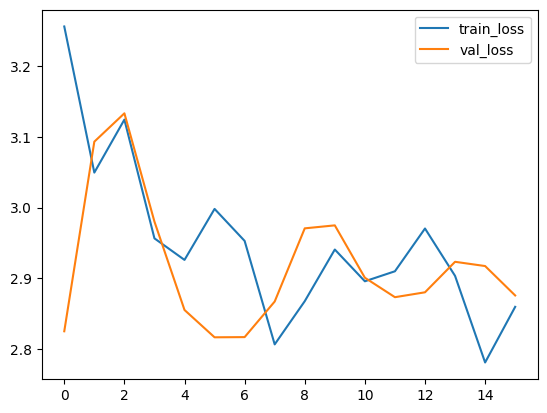

In [71]:
_ = log.plot()

In [72]:
model.partial_log_likelihood(*val).mean()

-2.8161948

In [73]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

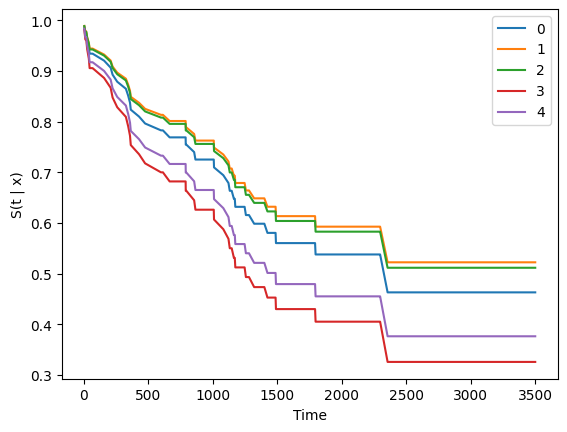

In [74]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [75]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()


0.504